In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from numba import njit
from quantecon import optimize as opti
from scipy.optimize import fsolve
from math import log

**SETUP**

In [3]:
β = 0.96
δ = 0.06
α = 0.36

params = β, δ, α

pi_ee = 0.9
mu_u_star = 0.10

In [4]:
nk = 400
k_low = 0.001 
k_high = 40
k_grid = np.linspace(k_low, k_high, nk)

**STATIONARY DISTRIBUTION**

In [5]:
#@njit
def error_statdistr(a):

    pi_ee = 0.9
    MC = [[pi_ee, 1-pi_ee],[a, 1-a]]
    #print(MC)
    
    t = 500    
    x_stat = [0.95, 0.05] #np.ones(2)*0.5
    x_vals = np.zeros((t,len(x_stat)))

    for ii in range(t):            
        for jj in range(2):
            x_vals[ii,jj] = x_stat[jj]

        x_stat = np.dot(x_stat,MC)

    #print(x_vals[-5:-1,:])       
    #print(x_stat)
    #print("the sum is:", np.sum(x_stat[:]))
    
    diff = x_stat[1] - 0.10
    
    return diff

In [6]:
ak = 1000
a_grid = np.linspace(0, 1, ak)
diffs = np.zeros(ak)
for aa in range(ak):
    diffs[aa] = error_statdistr(a_grid[aa])

In [7]:
#print(diffs)

In [8]:
@njit
def closest_gridpt(grid, point_in):
    pt_index  = np.argmin((point_in-grid)**2)
    
    return pt_index

In [9]:
ida = closest_gridpt(diffs, 0)
print(ida)
print(a_grid[ida])
pi_ue = round(a_grid[ida],2)

899
0.8998998998998999


In [10]:
MC = np.array([[pi_ee, 1-pi_ee],[pi_ue, 1-pi_ue]])
print(MC)

[[0.9 0.1]
 [0.9 0.1]]


**VFI**

In [11]:
@njit
def get_r(k_bar, u, params):
    β, δ, α = params
    
    r = α*(k_bar**(α-1))*(1-u)**(1-α)
    
    return r

In [12]:
@njit
def get_w(k_bar, u, params):
    β, δ, α = params
    
    w = (1-α)*(k_bar**α)*(1-u)**(-α)
    
    return w

In [13]:
#guess k_bar at steady state
k_bar = ((α*β)/(1-β*(1-δ)))**(1/(1-α))
print(k_bar)

r_bar = get_r(k_bar, mu_u_star, params)
w_bar = get_w(k_bar, mu_u_star, params)
print(r_bar)
print(w_bar)

7.211176392599507
0.09503723459520197
1.3537387901844178


In [14]:
@njit
def VFI_solver(k_grid, params, r, w, MC):
    eps = 0.0001
    max_iter = 1000

    β, δ, α = params
    
    V = np.zeros((len(k_grid),2))
    pol = np.zeros_like(V)
    
    crit = 1
    itr = 0
    
    while crit > eps and itr < max_iter:
        #print('Iteration: ', itr)
        V_new = np.zeros_like(V)
        epsilon = np.array([1,0])
        
        for ii,k in enumerate(k_grid):
            for ee,epsil in enumerate(epsilon):
                max_V = -999
                idx = 0

                for jj,kp in enumerate(k_grid): 
                    if (r*k + w*epsil + (1-δ)*k - kp) <= 0:
                        find_V = -99999999

                        if find_V > max_V:
                            max_V = find_V
                            idx = jj
                    else:
                        EV = np.dot(V[jj,:],MC[ee,:])
                        find_V = log(r*k + w*epsil + (1-δ)*k - kp) + β*EV

                        if find_V > max_V or ii == 0:
                            max_V = find_V
                            idx = jj
                
                V_new[ii,ee] = max_V
                pol[ii,ee] = k_grid[idx]
        
        crit = np.max(np.abs(V - V_new))
        
        V = V_new.copy()
        itr += 1
    
    print("the V difference is:", crit)
    
    return V, pol

In [15]:
V, pol = VFI_solver(k_grid, params, r_bar, w_bar, MC)
#print(V)

the V difference is: 9.662967828560909e-05


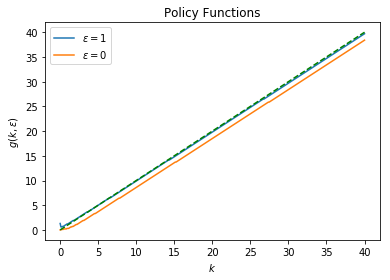

In [16]:
degree = np.zeros(nk)
for ii in range(nk):
    degree[ii] = k_grid[ii]

plt.plot(k_grid, pol[:,0], k_grid, pol[:,1])
plt.plot(k_grid, degree, 'g--')
#plt.plot( k_grid[0:30], pol[0:30,0], k_grid[0:30], pol[0:30,1], k_grid[0:30], degree[0:30])
plt.title('Policy Functions')
plt.xlabel('$k$')
plt.ylabel('$g(k,\epsilon)$')
plt.legend(('$\epsilon=1$', '$\epsilon=0$'))
plt.show()

**SIMULATION OVER TIME**

In [17]:
#closept = np.zeros_like(pol)
#for ee in range(2):
#    for jj in range(nk):
#        closept[jj,ee] = closest_gridpt(k_grid, pol[jj,ee])

In [18]:
@njit
def MC_simulation(k_grid, pol, k_bar):

    max_iter = 10000
    np.random.seed(10)
    
    MC_sim = np.zeros((max_iter,2))
    k_Id = np.zeros(max_iter)
    
    #status = np.array([1,0])
    e_draws = np.random.rand(max_iter)
    status = np.zeros(max_iter)
    
    for itr in range(max_iter):
        if e_draws[itr] <= 0.9:
            status[itr] = 1
        
        if itr == 0:
            MC_sim[itr,0] = np.random.choice(k_grid)
            MC_sim[itr,1] = status[itr]
            k_Id[itr] = closest_gridpt(k_grid, MC_sim[0,0])
            
        else:
            if MC_sim[itr-1,1] == 1:
                MC_sim[itr,0] = pol[int(k_Id[itr-1]),0]
            else:
                MC_sim[itr,0] = pol[int(k_Id[itr-1]),1]
            
            MC_sim[itr,1] = status[itr]
            
            k_Id[itr] = closest_gridpt(k_grid, MC_sim[itr,0])
                
    
    k_bar_sim = np.mean(MC_sim[:,0])
    
    crit = k_bar_sim - k_bar
    
    return crit #, MC_sim

In [19]:
#crit, MC_sim = MC_simulation(k_grid, pol, k_bar)
#print(crit)
#print(MC_sim)

**ITERATE SIMULATIONS TO GET K TO CONVERGE**

In [20]:
@njit
def MC_iteration(k, k_grid, mu_u_star, params, MC):
    eps = 0.0001
    max_iter = 10000
    
    crit = 1
    itr = 0
    np.random.seed(10)
    
    r = get_r(k, mu_u_star, params)
    w = get_w(k, mu_u_star, params)
    
    V, pol = VFI_solver(k_grid, params, r, w, MC)
    
    objective = MC_simulation(k_grid, pol, k)
    print("The objective is:", objective)
        
    return objective

In [21]:
@njit
def run_fun(k):
    nk = 200
    k_low = 0.001 
    k_high = 40
    k_grid = np.linspace(k_low, k_high, nk)
    mu_u_star = 0.10
    MC = np.array([[0.9, 0.1],[0.9, 0.1]])
    
    params = β, δ, α
    
    fun_res = MC_iteration(k, k_grid, mu_u_star, params, MC)
    
    return fun_res

In [22]:
#fun = lambda k: MC_iteration(k, k_grid, mu_u_star, params, MC)
k_star = opti.root_finding.newton_secant(run_fun, k_bar, maxiter=200)
#k_star = opti.root_finding.bisect(run_fun, 1, 10, k_bar)
#k_star = fsolve(fun, k_bar)

the V difference is: 9.994570624982657e-05
The objective is: -4.761872810238906
the V difference is: 9.993850701306428e-05
The objective is: -4.761051692599647
the V difference is: 9.793303734539904e-05
The objective is: 37.500951900005205
the V difference is: 9.777678278055646e-05
The objective is: -2.704529521412502
the V difference is: 9.749338539322139e-05
The objective is: 32.45516574982493
the V difference is: 9.907925459984313e-05
The objective is: -2.51648282047496
the V difference is: 9.584074702218004e-05
The objective is: -2.1553235644916695
the V difference is: 9.704900384122084e-05
The objective is: 31.841243314585494
the V difference is: 9.621800910508682e-05
The objective is: -1.981693437895264
the V difference is: 9.65407014987818e-05
The objective is: -1.7875163798978067
the V difference is: 9.937130126047578e-05
The objective is: 8.621131613265081
the V difference is: 9.704385413300542e-05
The objective is: -1.4264357616628267
the V difference is: 9.738405542591977e-0

The objective is: -0.12273422873833972
the V difference is: 9.656757893594659e-05
The objective is: 31.893192599997047
the V difference is: 9.801241496631974e-05
The objective is: 0.05600317742419225
the V difference is: 9.800173399199252e-05
The objective is: 0.05578810954062341
the V difference is: 9.938022732924878e-05
The objective is: -2.341670099999562
the V difference is: 9.793718182393718e-05
The objective is: -0.12377696247811798
the V difference is: 9.808811885747559e-05
The objective is: 0.2478779311730248
the V difference is: 9.798755438339413e-05
The objective is: -0.12276418163334402
the V difference is: 9.802091219768272e-05
The objective is: 0.05617450356450959
the V difference is: 9.801045185398038e-05
The objective is: 0.05596360897787722
the V difference is: 9.938022732924878e-05
The objective is: -2.341670099999562
the V difference is: 9.794551043285082e-05
The objective is: -0.12360954790185907
the V difference is: 9.809665407445323e-05
The objective is: 0.24805033

RuntimeError: Failed to converge

In [ ]:
#print("K_barhat equals K_bar at:", k_star.root)

**MANUAL BISECTION**

In [23]:
@njit
def MC_simulation2(k_grid, pol, k_bar):

    max_iter = 10000
    np.random.seed(0)
    
    MC_sim = np.zeros((max_iter,2))
    k_Id = np.zeros(max_iter)
    
    #status = np.array([1,0])
    e_draws = np.random.rand(max_iter)
    status = np.zeros(max_iter)
    for i in range(max_iter):
        if e_draws[i] <= 0.9:
            status[i] = 1
    
    for itr in range(max_iter):
        if itr == 0:
            MC_sim[itr,0] = np.random.choice(k_grid)
            MC_sim[itr,1] = status[itr]
            k_Id[itr] = closest_gridpt(k_grid, MC_sim[0,0])
            
        else:
            if MC_sim[itr-1,1] == 1:
                MC_sim[itr,0] = pol[int(k_Id[itr-1]),0]
            else:
                MC_sim[itr,0] = pol[int(k_Id[itr-1]),1]
            
            MC_sim[itr,1] = status[itr]
            
            k_Id[itr] = closest_gridpt(k_grid, MC_sim[itr,0])
                
    
    k_bar_sim = np.mean(MC_sim[:,0])
    
    #crit = abs(k_bar_sim - k_bar)
    crit = k_bar_sim - k_bar
    
    return crit, k_bar_sim, k_bar #MC_sim

In [28]:
eps = 1e-6
max_iter = 100 #10000

crit = 1
itr = 0
np.random.seed(0)

k = k_bar
a = k_bar - 6
b = k_bar + 6

result = np.zeros((max_iter,5))

while crit > eps and itr < max_iter:    
    r = get_r(k, mu_u_star, params)
    w = get_w(k, mu_u_star, params)
    
    V, pol = VFI_solver(k_grid, params, r, w, MC)
    
    objective, k_new, k_old = MC_simulation2(k_grid, pol, k)

    result[itr,0] = k_old
    result[itr,1] = k_new
    result[itr,2] = objective
    
    if objective < 0:
        b = k_old
        k = (a+b)/2
    else:
        a = k_old
        k = (a+b)/2
    
    result[itr,3] = a
    result[itr,4] = b
    
    crit = abs(objective)
    itr += 1

the V difference is: 9.662967828560909e-05
the V difference is: 9.879115021504958e-05
the V difference is: 9.653547169108379e-05
the V difference is: 9.867301690391628e-05
the V difference is: 9.606311324716899e-05
the V difference is: 9.820839528629222e-05
the V difference is: 9.96617800126387e-05
the V difference is: 9.813349763021506e-05
the V difference is: 9.656331428686826e-05
the V difference is: 9.944684758877997e-05
the V difference is: 9.881447500958984e-05
the V difference is: 9.913459612320707e-05
the V difference is: 9.929169255684656e-05
the V difference is: 9.936957014744507e-05
the V difference is: 9.940827892762627e-05
the V difference is: 9.942757787229084e-05
the V difference is: 9.943721335048394e-05
the V difference is: 9.94323969365496e-05
the V difference is: 9.942998782364043e-05
the V difference is: 9.943119248490007e-05
the V difference is: 9.943179472671204e-05
the V difference is: 9.943149361291148e-05
the V difference is: 9.943164417336448e-05


In [31]:
print(result[:itr,:])

[[ 7.21117639e+00  2.37932651e+00 -4.83184989e+00  1.21117639e+00
   7.21117639e+00]
 [ 4.21117639e+00  3.98307912e+01  3.56196148e+01  4.21117639e+00
   7.21117639e+00]
 [ 5.71117639e+00  3.94966341e+01  3.37854577e+01  5.71117639e+00
   7.21117639e+00]
 [ 6.46117639e+00  7.02601735e+00  5.64840960e-01  6.46117639e+00
   7.21117639e+00]
 [ 6.83617639e+00  3.21014283e+00 -3.62603357e+00  6.46117639e+00
   6.83617639e+00]
 [ 6.64867639e+00  4.56630942e+00 -2.08236697e+00  6.46117639e+00
   6.64867639e+00]
 [ 6.55492639e+00  5.80428349e+00 -7.50642907e-01  6.46117639e+00
   6.55492639e+00]
 [ 6.50805139e+00  6.40609300e+00 -1.01958391e-01  6.46117639e+00
   6.50805139e+00]
 [ 6.48461389e+00  6.58508602e+00  1.00472128e-01  6.48461389e+00
   6.50805139e+00]
 [ 6.49633264e+00  6.49647671e+00  1.44064167e-04  6.49633264e+00
   6.50805139e+00]
 [ 6.50219202e+00  6.40609300e+00 -9.60990161e-02  6.49633264e+00
   6.50219202e+00]
 [ 6.49926233e+00  6.49647671e+00 -2.78562333e-03  6.49633264e+00

**PLOTTING STEADY STATE RESULTS**

In [32]:
@njit
def MC_simulation_fin(k_grid, pol, k_bar):

    max_iter = 20000
    np.random.seed(0)
    
    MC_sim = np.zeros((max_iter,2))
    k_Id = np.zeros(max_iter)
    
    #status = np.array([1,0])
    e_draws = np.random.rand(max_iter)
    status = np.zeros(max_iter)
    for i in range(max_iter):
        if e_draws[i] <= 0.9:
            status[i] = 1
    
    for itr in range(max_iter):
        if itr == 0:
            MC_sim[itr,0] = np.random.choice(k_grid)
            MC_sim[itr,1] = status[itr]
            k_Id[itr] = closest_gridpt(k_grid, MC_sim[0,0])
            
        else:
            if MC_sim[itr-1,1] == 1:
                MC_sim[itr,0] = pol[int(k_Id[itr-1]),0]
            else:
                MC_sim[itr,0] = pol[int(k_Id[itr-1]),1]
            
            MC_sim[itr,1] = status[itr]
            
            k_Id[itr] = closest_gridpt(k_grid, MC_sim[itr,0])
                
    
    k_bar_sim = np.sum(MC_sim[:,0])/max_iter
    
    crit = abs(k_bar_sim - k_bar)
    
    return crit, MC_sim

In [33]:
crit, MC_sim = MC_simulation_fin(k_grid, pol, 6.49647671)#k_star.root)

In [34]:
print(crit)
print(MC_sim)

0.5557054084963884
[[11.73003008  1.        ]
 [11.8302782   1.        ]
 [11.93052632  1.        ]
 ...
 [ 5.81539098  1.        ]
 [ 5.9156391   1.        ]
 [ 6.01588722  1.        ]]


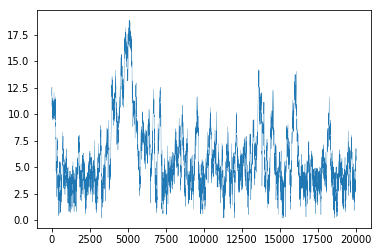

In [35]:
t_grid = np.linspace(0, 20000, 20000)
plt.plot(t_grid, MC_sim[:,0], lw=0.3)
plt.show()

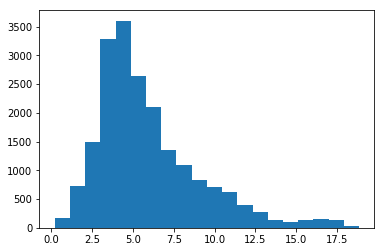

In [36]:
plt.hist(MC_sim[:,0], bins=20)
plt.show()

In [37]:
get_r(6.49647671,mu_u_star,params)

0.10160237499639323